<a href="https://colab.research.google.com/github/DHKing7/dahyunk/blob/main/ResNet_pothole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/캡스톤디자인

/content/drive/MyDrive/캡스톤디자인


In [ ]:
!pip uninstall albumentations
!pip install opencv-python-headless==4.5.2.52
!pip install albumentations==0.5.2.

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 38.2 MB 1.1 MB/s 
     |████████████████████████████████| 72 kB 710 kB/s 
     |████████████████████████████████| 948 kB 11.4 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import cv2
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import json
import albumentations
import albumentations.pytorch

In [ ]:
ls

Annotations/  model_20.pt   retina_65.pt       Tutorial-Book-Utils/
Images/       retina_35.pt  test_annotations/
model_10.pt   retina_50.pt  test_images/


In [ ]:
cd 2. filled

/content/drive/MyDrive/캡스톤디자인/2. filled


In [ ]:
print(len(os.listdir('Annotations/')))
print(len(os.listdir('Images/Images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

539
539
135
135


In [ ]:
def generate_box(obj):
    
    xmin = obj['bbox'][0]
    ymin = obj['bbox'][1]
    xmax = obj['bbox'][0]+obj['bbox'][2]
    ymax = obj['bbox'][1]+obj['bbox'][3]
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj['category_id'] == 7: 
        return 7

    elif obj['category_id'] == 8: 
        return 8

    elif obj['category_id'] == 9:
      return 9
    return 0


def generate_target(file): 
    with open(f'{file}') as f:
        data = json.load(f)

        boxes = []
        labels = []
        for i in data['annotations']:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 7 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 8 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        
        elif annotation['labels'][idx] == 9 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects


class PotholeDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    img = Image.open(img_path).convert('RGB')
    target = generate_target(label_path)

    to_tensor = torchvision.transforms.ToTensor()

    if self.transform:
      img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
      target['boxes'] = torch.as_tensor(transform_target)

    img = to_tensor(img)

    return img, target

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
class BboxAugmentationDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    target = generate_target(label_path)

    if self.transform:
      transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
      image = transformed['image']
      target = {'boxes':torch.as_tensor(transformed['bboxes']), 'labels':torch.as_tensor(transformed['labels'])}


    return image, target

In [ ]:
torchvision_transform = albumentations.Compose(
    [albumentations.Resize(320, 320),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [ ]:
dataset = BboxAugmentationDataset('Images/Images/',torchvision_transform)
test_dataset = BboxAugmentationDataset('test_images/',torchvision_transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn = collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn = collate_fn)

In [ ]:
img, annot = dataset[1]
print(np.shape(img))
print(type(annot))


torch.Size([3, 320, 320])
<class 'dict'>


In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 25 kB/s 
     |████████████████████████████████| 12.7 MB 37.5 MB/s 
     |████████████████████████████████| 7.6 MB 4.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.8.1+cu101'

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes= 10, pretrained=False, pretrained_backbone= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
num_epochs = 65
retina.to(device)

params = [p for p in retina.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005,
                            momentum = 0.9, weight_decay = 0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  start = time.time()
  retina.train()

  i = 0
  epoch_loss = 0
  for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = retina(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    i += 1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses 
  print(epoch_loss, f'time: {time.time() - start}')


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(256.7003, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 290.76014614105225
tensor(247.5555, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 56.224043130874634
tensor(244.1684, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.541090965270996
tensor(233.6083, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.57439947128296
tensor(236.8127, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.35997796058655
tensor(230.3619, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.383113622665405
tensor(231.2625, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.40540075302124
tensor(231.7484, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.37968420982361
tensor(229.3229, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 55.36474680900574
tensor(228.6312, device='cuda:0', dtype=torch.float64, grad_fn=<AddBa

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [ ]:
torch.load('retina_65.pt')

In [ ]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]['scores']):
      if score > threshold:
        idx_list.append(idx)

    preds[id]['boxes'] = preds[id]['boxes'][idx_list]
    preds[id]['labels'] = preds[id]['labels'][idx_list]
    preds[id]['scores'] = preds[id]['scores'][idx_list]

  
  return preds

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
  im =list(img.to(device) for img in im)
  # annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

  for t in annot:
    labels += t['labels']

  with torch.no_grad():
    preds_adj = make_prediction(retina, im, 0.1)
    preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
    preds_adj_all.append(preds_adj)
    annot_all.append(annot)

100%|██████████| 68/68 [00:48<00:00,  1.39it/s]


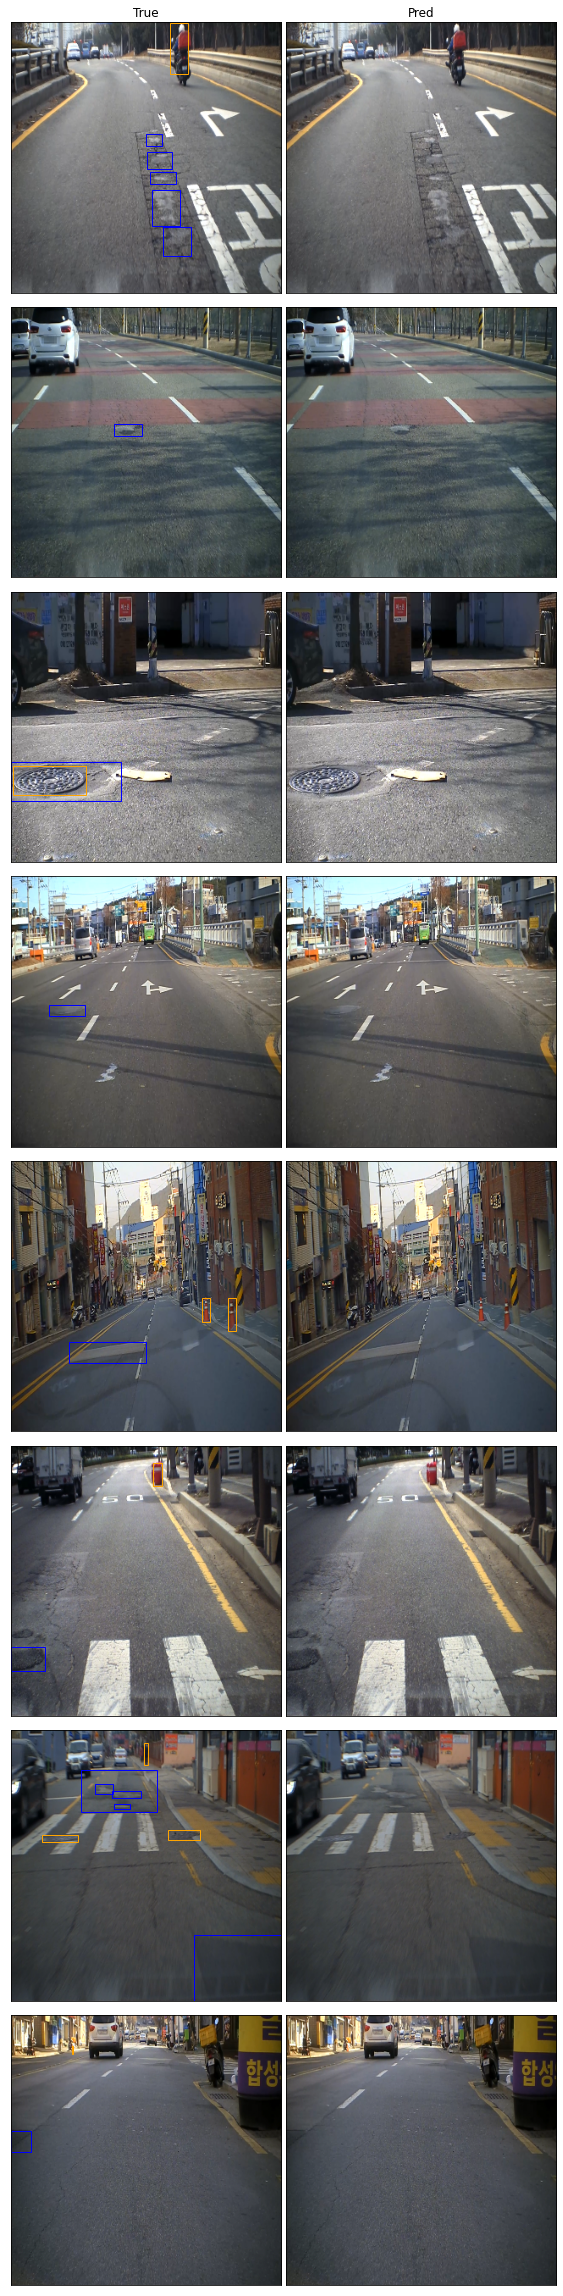

In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
  pos = batch_i * 4 + 1
  for sample_i in range(len(im)):

    img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
    axes[(pos)//2, 1-((pos)%2)].imshow(img)
    for rect in rects:
      axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
    img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
    axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
    for rect in rects:
      axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

    pos += 2

  batch_i += 1
  if batch_i == 4:
    break

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

# %cd /content/drive/MyDrive/캡스톤디자인/1. pothole
# import utils_ObjectDetection as utils

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/캡스톤디자인/2. filled/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
  sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

In [ ]:
true_positives, pred_score, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_score, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.3756916555042793
AP : tensor([0.3805, 0.3708], dtype=torch.float64)


In [ ]:
print(preds_adj_all)

[[{'boxes': tensor([[775.9132, 400.6146, 815.6118, 412.9342]]), 'scores': tensor([0.1067]), 'labels': tensor([8])}, {'boxes': tensor([[ 97.4282, 243.3070, 221.2658, 251.0830]]), 'scores': tensor([0.1068]), 'labels': tensor([8])}], [{'boxes': tensor([[519.9958, 532.5900, 582.1734, 547.6650]]), 'scores': tensor([0.1068]), 'labels': tensor([8])}, {'boxes': tensor([[799.9352, 579.8953, 906.1028, 588.0146]]), 'scores': tensor([0.1041]), 'labels': tensor([8])}], [{'boxes': tensor([[528.1218, 312.4080, 648.4535, 320.2798]]), 'scores': tensor([0.1096]), 'labels': tensor([8])}, {'boxes': tensor([[ 939.0057,  288.4428, 1027.4639,  299.4723]]), 'scores': tensor([0.1355]), 'labels': tensor([8])}], [{'boxes': tensor([[424.2032, 144.8881, 564.9971, 151.7772],
        [626.1018, 496.0943, 734.4030, 503.8863]]), 'scores': tensor([0.1245, 0.1219]), 'labels': tensor([8, 8])}, {'boxes': tensor([[  0.0000, 142.3989,  96.6603, 176.5965],
        [563.3230,  64.0868, 684.0741, 138.8627]]), 'scores': tensor(

In [ ]:
print(preds_adj)

[{'boxes': tensor([], size=(0, 4)), 'scores': tensor([]), 'labels': tensor([], dtype=torch.int64)}]


In [ ]:
print(annot_all)

[({'boxes': tensor([[792.9203, 451.7699, 842.4779, 512.8318],
        [769.4691, 400.0000, 794.2478, 433.1859],
        [803.0974, 400.0000, 834.9557, 407.9646]]), 'labels': tensor([8, 8, 8])}, {'boxes': tensor([[561.7231, 320.6376, 656.4570, 352.2156]]), 'labels': tensor([8])}), ({'boxes': tensor([[541.8742, 535.8453, 585.2820, 550.0735],
        [660.0267, 411.8309, 682.7807, 420.8679],
        [500.3740, 587.2271, 522.9421, 600.9047],
        [529.3533, 579.1107, 562.5854, 586.5562]]), 'labels': tensor([8, 8, 8, 8])}, {'boxes': tensor([[ 819.5000,  564.5000,  965.5000,  591.5000],
        [1053.5000,  495.5000, 1090.5000,  531.5000],
        [ 295.5000,  336.5000,  317.5000,  411.5000]]), 'labels': tensor([0, 8, 0])}), ({'boxes': tensor([[327.3810, 386.3095, 386.9048, 401.7857]]), 'labels': tensor([8])}, {'boxes': tensor([[ 847.5000,  426.5000, 1202.5000,  481.5000],
        [ 956.5000,  289.5000, 1019.5000,  301.5000],
        [ 862.2222,   90.3704,  880.7407,  131.1111]]), 'labels

In [ ]:
print(annot)

({'boxes': tensor([[600.8163, 480.1555, 738.8922, 517.4733]]), 'labels': tensor([8])}, {'boxes': tensor([[7.4798e+02, 2.3156e+02, 9.4611e+02, 5.1483e+02],
        [6.7286e+02, 2.6680e+01, 7.0995e+02, 1.0477e+02],
        [5.8566e+02, 9.1103e+00, 6.2796e+02, 1.1518e+02],
        [5.1669e+02, 6.5074e-01, 5.5248e+02, 6.5724e+01],
        [7.4465e+02, 3.3694e+02, 8.1229e+02, 4.7222e+02],
        [9.2502e+02, 2.8120e+02, 9.6761e+02, 2.9999e+02],
        [1.0108e+03, 2.6116e+02, 1.1148e+03, 2.7932e+02]]), 'labels': tensor([0, 0, 0, 0, 8, 8, 8])})
